In [2]:
%matplotlib widget

In [90]:
import requests as rq
import csv
import pandas as pd
import numpy as np
import plotly.express as px
import os
import plotly.graph_objects as go
from matplotlib import pyplot as plt

In [3]:
# Init Mapbox API
# Extract token
mapbox_token = os.getenv("MAPBOX_API_KEY")
print(type(mapbox_token))

# Set token using Plotly Express set function
px.set_mapbox_access_token(mapbox_token)

<class 'str'>


In [4]:
# def read_remote_csv(url):
#     # read csv from url
#     response = rq.get(url)
#     csv_reader = csv.reader(response.text.split('\n'), delimiter=',')
#     header = next(csv_reader)

#     csv_data = [row for row in csv_reader]
#     return (header, csv_data)

def read_local_csv(file_path):
    # read csv from url
    with open(file_path,'rt') as file:
        csv_reader = csv.reader(file, delimiter=',')
        header = next(csv_reader)

        csv_data = [row for row in csv_reader]
        
    jh_data = pd.DataFrame.from_records(csv_data, columns=header)    
    return jh_data

In [5]:
#ny_times_timeseries_url = r'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

# John's Hopkins
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/03-31-2020.csv # regular format

In [6]:
# # NY Times data
# header, csv_data = read_remote_csv(ny_times_timeseries_url)
# case_data = pd.DataFrame.from_records(data=csv_data,columns=header)
# case_data['date'] = pd.to_datetime(case_data['date'])
# case_data[['cases','deaths']] = case_data[['cases','deaths']].applymap(int)
# case_data.head()

In [7]:
# case_data.pivot_table(index='date', columns='state', values='cases', aggfunc=sum).plot.line(figsize=(15,15))


In [5]:
daily_data_path = r'../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
data_files = sorted(os.listdir(daily_data_path))
data_dates = pd.to_datetime([file[0:10] for file in data_files if file[10:]=='.csv'])

last_date = data_dates.max()

In [6]:
renames={
        'Province_State': 'Province/State',
        'Country_Region':'Country/Region',
        'Last_Update':'Last Update'
        }

def read_jh_data(date):
    
    datestr = date.strftime('%m-%d-%Y')
    filename = f'{datestr}.csv'
    
    last_file_path = os.path.join(daily_data_path, filename)
    
    jh_data = read_local_csv(last_file_path)
    jh_data['Date'] = date
    
    
    jh_data = jh_data.rename(columns=renames)

    #jh_data[['Lat','Long_','Confirmed','Deaths','Recovered','Active']] = jh_data[['Lat','Long_','Confirmed','Deaths','Recovered','Active']].applymap(lambda x: float(x) if x != "" else np.nan)
    
    return jh_data

In [10]:
# jh_lastday = read_jh_data(last_date)
# jh_lastday.head()

FIPS     Admin2  Province/State Country/Region          Last Update  \
0  45001  Abbeville  South Carolina             US  2020-04-06 23:22:15   
1  22001     Acadia       Louisiana             US  2020-04-06 23:22:15   
2  51001   Accomack        Virginia             US  2020-04-06 23:22:15   
3  16001        Ada           Idaho             US  2020-04-06 23:22:15   
4  19001      Adair            Iowa             US  2020-04-06 23:22:15   

                  Lat                Long_ Confirmed Deaths Recovered Active  \
0         34.22333378         -82.46170658         6      0         0      0   
1  30.295064899999996         -92.41419698        79      2         0      0   
2         37.76707161         -75.63234615        11      0         0      0   
3          43.4526575  -116.24155159999998       402      3         0      0   
4         41.33075609         -94.47105874         1      0         0      0   

                    Combined_Key       Date  
0  Abbeville, South Carolina, US 2020-04-06  
1          Acadia, Louisiana, US 2020-04-06  
2         Accomack, Virginia, US 2020-04-06  
3                 Ada, Idaho, US 2020-04-06  
4                Adair, Iowa, US 2020-04-06

In [7]:

all_days = pd.concat([read_jh_data(dt) for dt in data_dates])

all_days[['Lat','Long_','Confirmed','Deaths','Recovered','Active']] = all_days[['Lat','Long_','Confirmed','Deaths','Recovered','Active']].applymap(lambda x: float(x) if x != "" else np.nan)

In [8]:
all_days.shape

(56804, 17)

In [9]:
us_data = all_days.loc[(all_days['Country/Region']=='US')&(all_days['Date']==last_date),:]

In [10]:
us_data.head().dtypes

ï»¿Province/State            object
Country/Region               object
Last Update                  object
Confirmed                   float64
Deaths                      float64
Recovered                   float64
Date                 datetime64[ns]
Province/State               object
Latitude                     object
Longitude                    object
ï»¿FIPS                      object
Admin2                       object
Lat                         float64
Long_                       float64
Active                      float64
Combined_Key                 object
FIPS                         object
dtype: object

# Geographical Hotspots
## Counties

In [11]:
# PLot US
us_scatter_map_box = px.scatter_mapbox(
    us_data,
    lat="Lat",
    lon="Long_",
    size="Confirmed",
    color="Deaths",
    hover_name='Admin2',

)

fig = go.Figure(us_scatter_map_box
)

fig.update_layout(
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40,
            lon=-99
        ),
        pitch=0,
        zoom=3
    )
)

fig.write_image('maps/us_cases.png')


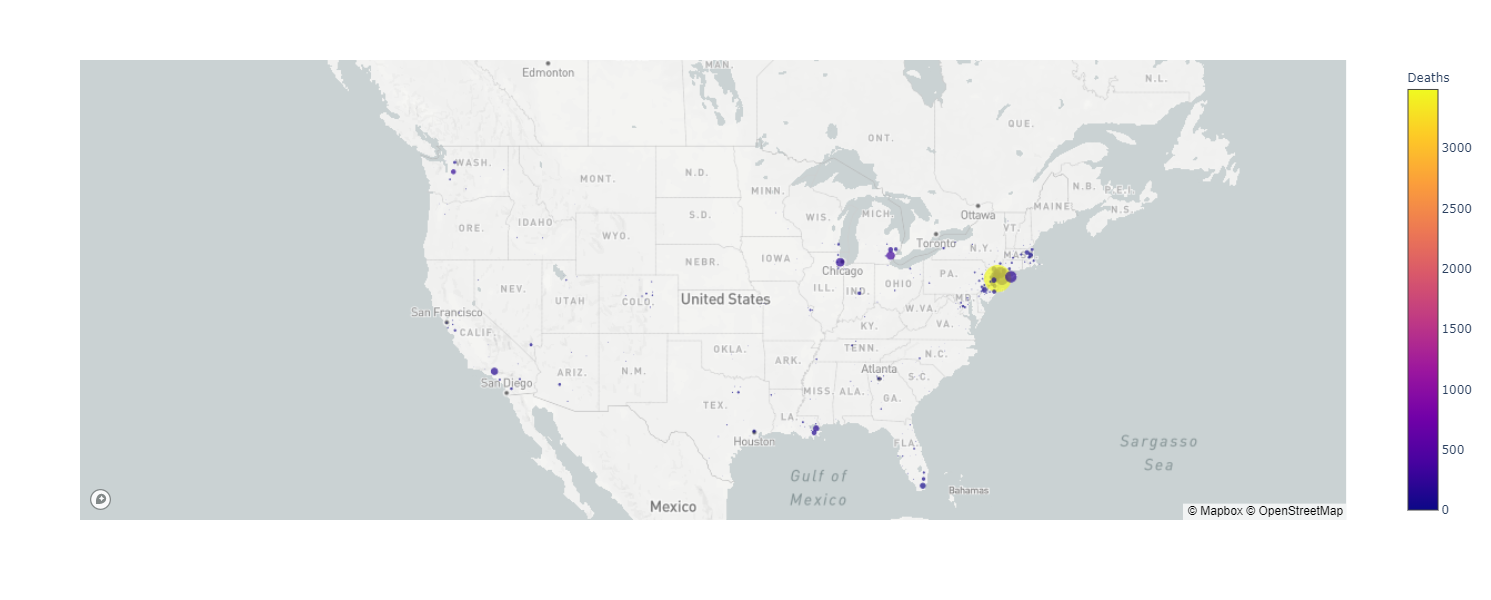

In [12]:
fig

## States

In [15]:
us_data_state = us_data.groupby('Province/State').sum()[['Confirmed','Deaths']]
us_data_state[['Lat','Long_']] = us_data.groupby('Province/State').median()[['Lat','Long_']]
#us_data_state

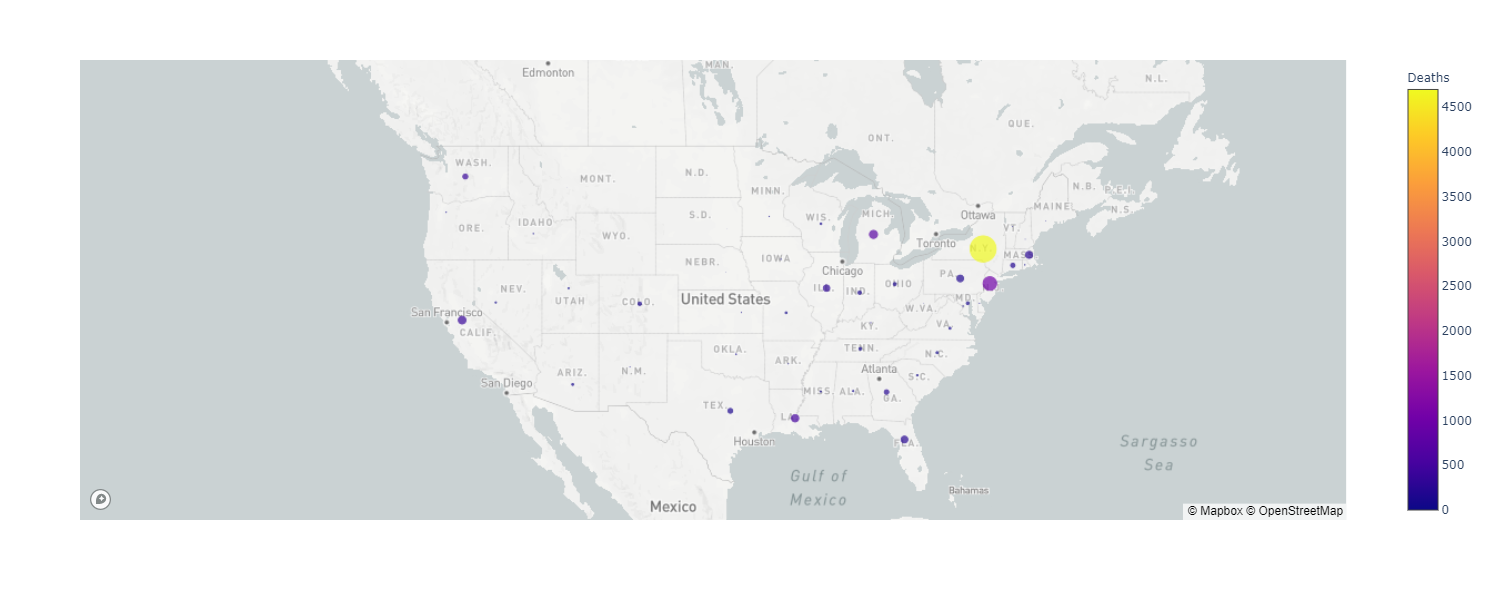

In [16]:

us_scatter_map_box = px.scatter_mapbox(
    us_data_state,
    lat="Lat",
    lon="Long_",
    size="Confirmed",
    color="Deaths",
    hover_name=us_data_state.index
)

fig = go.Figure(us_scatter_map_box
)

fig.update_layout(
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40,
            lon=-99
        ),
        pitch=0,
        zoom=3
    )
)

## US states by confirmed cases, deaths

In [17]:
us_data_state.sort_values('Confirmed',ascending=False).plot(kind='bar',y=['Confirmed','Deaths'],figsize=(15,8), color=['red','black'])
# us_data_state.sort_values('Confirmed',ascending=False).plot(kind='bar',y=['Deaths',color='black')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Over time
Countries over time


In [92]:
# Including note for students of FinTech class
# 1. Googled "pandas in group rolling average"
# 2. Found this response on Stack Overflow:
#     https://stackoverflow.com/questions/53339021/python-pandas-calculate-moving-average-within-group
# 3. Copy snipped from most upvoted/selected solution response
#     df['moving'] = df.groupby('object')['value'].transform(lambda x: x.rolling(10, 1).mean())

# all_days.sort
country_state_date_level = all_days.groupby(['Country/Region','Province/State','Date']).sum()[['Confirmed','Deaths']].sort_values('Date')


country_state_date_level.head()


Confirmed  Deaths
Country/Region Province/State  Date                         
Sri Lanka                      2020-02-01        1.0     0.0
Mainland China Yunnan          2020-02-01       93.0     0.0
               Shaanxi         2020-02-01      101.0     0.0
US             Santa Clara, CA 2020-02-01        1.0     0.0
Sweden                         2020-02-01        1.0     0.0

In [93]:
country_state_date_level[['Confirmed - avg 5d','Deaths - avg 5d']] = country_state_date_level.groupby(['Country/Region','Province/State'])[['Confirmed','Deaths']].transform(lambda x: x.rolling(5, 1).mean())

In [94]:
country_state_date_level #.head()

Confirmed  Deaths  \
Country/Region Province/State               Date                            
Sri Lanka                                   2020-02-01        1.0     0.0   
Mainland China Yunnan                       2020-02-01       93.0     0.0   
               Shaanxi                      2020-02-01      101.0     0.0   
US             Santa Clara, CA              2020-02-01        1.0     0.0   
Sweden                                      2020-02-01        1.0     0.0   
...                                                           ...     ...   
Iran                                        2020-04-06    60500.0  3739.0   
Brunei                                      2020-04-06      135.0     1.0   
United Kingdom Cayman Islands               2020-04-06       39.0     1.0   
Australia      Australian Capital Territory 2020-04-06       96.0     2.0   
US             Kentucky                     2020-04-06      955.0    45.0   

                                                        Confirmed - avg 5d  \
Country/Region Province/State               Date                             
Sri Lanka                                   2020-02-01                 1.0   
Mainland China Yunnan                       2020-02-01                93.0   
               Shaanxi                      2020-02-01               101.0   
US             Santa Clara, CA              2020-02-01                 1.0   
Sweden                                      2020-02-01                 1.0   
...                                                                    ...   
Iran                                        2020-04-06             55624.0   
Brunei                                      2020-04-06               134.4   
United Kingdom Cayman Islands               2020-04-06                33.0   
Australia      Australian Capital Territory 2020-04-06                92.6   
US             Kentucky                     2020-04-06               873.4   

                                                        Deaths - avg 5d  
Country/Region Province/State               Date                         
Sri Lanka                                   2020-02-01              0.0  
Mainland China Yunnan                       2020-02-01              0.0  
               Shaanxi                      2020-02-01              0.0  
US             Santa Clara, CA              2020-02-01              0.0  
Sweden                                      2020-02-01              0.0  
...                                                                 ...  
Iran                                        2020-04-06           3449.6  
Brunei                                      2020-04-06              1.0  
United Kingdom Cayman Islands               2020-04-06              1.0  
Australia      Australian Capital Territory 2020-04-06              1.6  
US             Kentucky                     2020-04-06             39.0  

[11846 rows x 4 columns]

In [95]:
country_state_date_level[['Confirmed - avg 5d - chg','Deaths - avg 5d chg']] = country_state_date_level.groupby(['Country/Region','Province/State'])[['Confirmed - avg 5d','Deaths - avg 5d']].diff()

In [96]:
country_state_date_level.loc['US'].loc['New York']

Confirmed  Deaths  Confirmed - avg 5d  Deaths - avg 5d  \
Date                                                                 
2020-03-10      173.0     0.0          173.000000              0.0   
2020-03-11      220.0     0.0          196.500000              0.0   
2020-03-12      328.0     0.0          240.333333              0.0   
2020-03-14      525.0     2.0          311.500000              0.5   
2020-03-15      732.0     3.0          395.600000              1.0   
2020-03-16      967.0    10.0          554.400000              3.0   
2020-03-17     1706.0    13.0          851.600000              5.6   
2020-03-18     2495.0    16.0         1285.000000              8.8   
2020-03-19     5365.0    34.0         2253.000000             15.2   
2020-03-20     8310.0    42.0         3768.600000             23.0   
2020-03-21    11710.0    60.0         5917.200000             33.0   
2020-03-22    15800.0   117.0         8736.000000             53.8   
2020-03-23    20884.0   158.0        12413.800000             82.2   
2020-03-24    25681.0   210.0        16477.000000            117.4   
2020-03-25    30841.0   285.0        20983.200000            166.0   
2020-03-26    37877.0   385.0        26216.600000            231.0   
2020-03-27    44876.0   527.0        32031.800000            313.0   
2020-03-28    52410.0   728.0        38337.000000            427.0   
2020-03-29    59648.0   965.0        45130.400000            578.0   
2020-03-30    66663.0  1218.0        52294.800000            764.6   
2020-03-31    75833.0  1550.0        59886.000000            997.6   
2020-04-01    83948.0  1941.0        67700.400000           1280.4   
2020-04-02    92506.0  2373.0        75719.600000           1609.4   
2020-04-03   102987.0  2935.0        84387.400000           2003.4   
2020-04-04   113833.0  3565.0        93821.400000           2472.8   
2020-04-05   123160.0  4159.0       103286.800000           2994.6   
2020-04-06   131815.0  4698.0       112860.200000           3546.0   

            Confirmed - avg 5d - chg  Deaths - avg 5d chg  
Date                                                       
2020-03-10                       NaN                  NaN  
2020-03-11                 23.500000                  0.0  
2020-03-12                 43.833333                  0.0  
2020-03-14                 71.166667                  0.5  
2020-03-15                 84.100000                  0.5  
2020-03-16                158.800000                  2.0  
2020-03-17                297.200000                  2.6  
2020-03-18                433.400000                  3.2  
2020-03-19                968.000000                  6.4  
2020-03-20               1515.600000                  7.8  
2020-03-21               2148.600000                 10.0  
2020-03-22               2818.800000                 20.8  
2020-03-23               3677.800000                 28.4  
2020-03-24               4063.200000                 35.2  
2020-03-25               4506.200000                 48.6  
2020-03-26               5233.400000                 65.0  
2020-03-27               5815.200000                 82.0  
2020-03-28               6305.200000                114.0  
2020-03-29               6793.400000                151.0  
2020-03-30               7164.400000                186.6  
2020-03-31               7591.200000                233.0  
2020-04-01               7814.400000                282.8  
2020-04-02               8019.200000                329.0  
2020-04-03               8667.800000                394.0  
2020-04-04               9434.000000                469.4  
2020-04-05               9465.400000                521.8  
2020-04-06               9573.400000                551.4

## Cases over time, by country

In [107]:
country_date_level = all_days.groupby(['Country/Region','Date']).sum()[['Confirmed']].sort_values('Date').reset_index()

Simply plot cases over time by country.


In [114]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
threshold = 100000 # threshold just to reduce number of countries that are displayed.
for country, data in country_date_level.groupby('Country/Region'):
    if data['Confirmed'].sum()>=threshold:
        data.plot(x='Date',y='Confirmed',ax=ax,label=country)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

* Wow, China's ability to deal with the spread is incredible! Perhaps some incredulity is in order?
* US is outta control

In [97]:
#cty_state_pivot = country_state_date_level.pivot_table(index='Date',columns=['Country/Region'],values=['Confirmed - avg 5d - chg','Confirmed'],aggfunc=sum)

#.plot(x='Confirmed',y='Confirmed - avg 5d - chg')

In [113]:
#cty_state_pivot['Confirmed'].plot(figsize=(20,20))

# Flattening the curve

As per [How to tell if we are beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc&feature=youtu.be)

Plot loglog of new cases vs current confirmed. At exponential growth, new cases will be a linear function of confirmed cases (recovered, non-carriers not withstanding), with the slope being the transmission rate.

"Flattening the curve means" to flatten this slope, so that the proportion of new cases, relative to the number of carriers drops. This is a necessary condition for the total number of cases to decline, as people recover.

Here I draw analysis various regions, as per the John's Hopkins data.

In [89]:
cty_state_pivot = country_state_date_level.loc['New Zealand',:].plot(x='Confirmed',y='Confirmed - avg 5d - chg',loglog=True) 
plt.xscale('log')
plt.yscale('log')
plt.title('New Zealand\nNewly confirmed cases vs total cases')

plt.legend().remove()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [85]:
def filter_by_min_threshold_confirmed(states,threshold=1000):
    has_enough_cases = states.groupby('Province/State')['Confirmed'].max()>=threshold
       
    return states.reset_index().set_index('Province/State').loc[has_enough_cases]


def plot_states(states,country_name):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'State cases for: {country_name}')
    states = states.reset_index().sort_values(['Province/State','Date']).groupby('Province/State')

    for state_name, state_data in states:
        state_data.plot(x='Confirmed',y='Confirmed - avg 5d - chg', loglog=True, ax=ax, label=state_name)

#country_state_date_level.loc['Australia',:].groupby('Province/State')['Confirmed'].max()>=100 

def plot_states_min_within_country(country_name='Australia',threshold=1000):
    states = country_state_date_level.loc[country_name,:]

    states_with_min = filter_by_min_threshold_confirmed(states,threshold)

    plot_states(states_with_min,country_name)


plot_states_min_within_country('Australia',100)

#aus_states_with_min.plot(x='Confirmed',y='Confirmed - avg 5d - chg', loglog=True)


# has_enough_cases = min_threshold_confirmed(aus_states)
# has_enough_cases

# aus_states.reset_index().set_index('Province/State').loc[has_enough_cases]



#has_enough_cases[0]

#aus_states = min_threshold_confirmed(country_state_date_level.loc['Australia',:])

#aus_states#
#plt.legend(country_state_date_level.loc['Australia',:].index[0].distinct())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# US by state
No end in sight

In [115]:
plot_states_min_within_country('US',threshold=5000)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [116]:
country_state_date_level

Confirmed  Deaths  \
Country/Region Province/State               Date                            
Sri Lanka                                   2020-02-01        1.0     0.0   
Mainland China Yunnan                       2020-02-01       93.0     0.0   
               Shaanxi                      2020-02-01      101.0     0.0   
US             Santa Clara, CA              2020-02-01        1.0     0.0   
Sweden                                      2020-02-01        1.0     0.0   
...                                                           ...     ...   
Iran                                        2020-04-06    60500.0  3739.0   
Brunei                                      2020-04-06      135.0     1.0   
United Kingdom Cayman Islands               2020-04-06       39.0     1.0   
Australia      Australian Capital Territory 2020-04-06       96.0     2.0   
US             Kentucky                     2020-04-06      955.0    45.0   

                                                        Confirmed - avg 5d  \
Country/Region Province/State               Date                             
Sri Lanka                                   2020-02-01                 1.0   
Mainland China Yunnan                       2020-02-01                93.0   
               Shaanxi                      2020-02-01               101.0   
US             Santa Clara, CA              2020-02-01                 1.0   
Sweden                                      2020-02-01                 1.0   
...                                                                    ...   
Iran                                        2020-04-06             55624.0   
Brunei                                      2020-04-06               134.4   
United Kingdom Cayman Islands               2020-04-06                33.0   
Australia      Australian Capital Territory 2020-04-06                92.6   
US             Kentucky                     2020-04-06               873.4   

                                                        Deaths - avg 5d  \
Country/Region Province/State               Date                          
Sri Lanka                                   2020-02-01              0.0   
Mainland China Yunnan                       2020-02-01              0.0   
               Shaanxi                      2020-02-01              0.0   
US             Santa Clara, CA              2020-02-01              0.0   
Sweden                                      2020-02-01              0.0   
...                                                                 ...   
Iran                                        2020-04-06           3449.6   
Brunei                                      2020-04-06              1.0   
United Kingdom Cayman Islands               2020-04-06              1.0   
Australia      Australian Capital Territory 2020-04-06              1.6   
US             Kentucky                     2020-04-06             39.0   

                                                        Confirmed - avg 5d - chg  \
Country/Region Province/State               Date                                   
Sri Lanka                                   2020-02-01                       NaN   
Mainland China Yunnan                       2020-02-01                       NaN   
               Shaanxi                      2020-02-01                       NaN   
US             Santa Clara, CA              2020-02-01                       NaN   
Sweden                                      2020-02-01                       NaN   
...                                                                          ...   
Iran                                        2020-04-06                    2581.4   
Brunei                                      2020-04-06                       0.8   
United Kingdom Cayman Islands               2020-04-06                       3.4   
Australia      Australian Capital Territory 2020-04-06                       2.4   
US             Kentucky                     2020-04-06 

In [ ]:
country_state_date_level_daily_average

# NZ geo distribution is non-interesting when we have only one data point

In [ ]:
nz_data = us_data = all_days.loc[(all_days['Country_Region']=='New Zealand')&(all_days['Date']==last_date),:] 
nz_data.head()

In [ ]:
nz_scatter_map_box = px.scatter_mapbox(
    nz_data,
    lat="Lat",
    lon="Long_",
    size="Confirmed",
    color="Deaths",
    hover_name='Admin2',
)


fig = go.Figure(nz_scatter_map_box
)

fig.update_layout(
    mapbox=dict(
        accesstoken=mapbox_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=-41,
            lon=174
        ),
        pitch=0,
        zoom=4.2
    )
)


fig.write_image('maps/nz_cases.png')

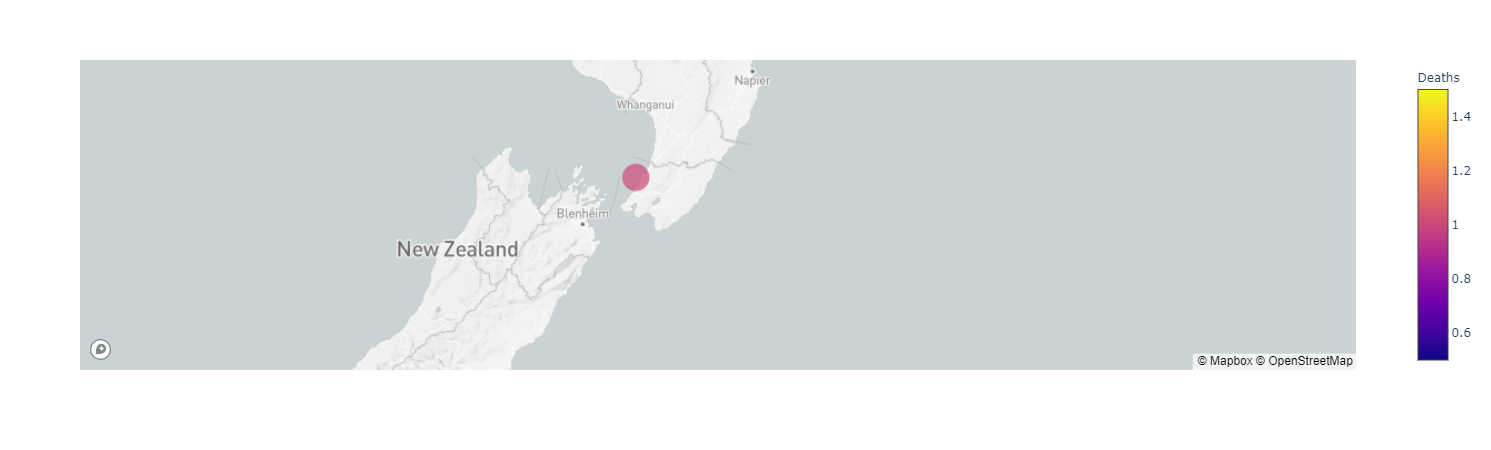

In [22]:
fig

![nz cases](maps/nz_cases.png)